## Assignment 5  EDA Best Practices

### Author: jd3631 Chloe Du

Objective:

Feature creation based on benchmark,

EDA,

K-means clustering,

Anomaly Detection

#### Data Preparation

In [174]:
#import necessary libraries
import numpy as np 
import pandas as pd

from scipy import stats  #for some statistics
from scipy.stats import norm, skew


import matplotlib.pyplot as plt # for visulisation
import seaborn as sns
color = sns.color_palette()
sns.set_style('whitegrid')
%matplotlib inline

import warnings 
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn  #ignore warnings (from sklearn and seaborn)

from plotly.offline import init_notebook_mode, iplot #for ipot visulisation
import plotly.figure_factory as ff
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')
import plotly.graph_objs as go
import chart_studio.plotly as py
import plotly
from plotly.subplots import make_subplots
import plotly.express as px

from plotly.offline import init_notebook_mode,iplot,plot
init_notebook_mode(connected=True) 

In [175]:
# Now to import and put the dataset 
df = pd.read_csv("/Users/jiayangdu/Desktop/Columbia University /APAN 5420/inpatientCharges.csv")
df.shape
# This original dataset has 163,065 rows and 12 columns

(163065, 12)

In [176]:
#something wrong with the columns, some are not callable, so I just rename them
df.columns= ['DRG Definition','Provider Id','Provider Name','Provider Street Address','Provider City','Provider State','Provider Zip Code','Hospital Referral Region Description','Total Discharges','Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']

In [177]:
# convert datatype
df['Provider Id'] = df['Provider Id'].apply(lambda x:str(x))
df['Provider Zip Code'] = df['Provider Zip Code'].apply(lambda x:str(x))

num_cols = ['Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
df[num_cols] = df[num_cols].replace({'\$':''}, regex = True)

In [178]:
df['Average Covered Charges($)'] = df['Average Covered Charges($)'].apply(lambda x:float(x))
df['Average Total Payments($)'] = df['Average Total Payments($)'].apply(lambda x:float(x))
df['Average Medicare Payments($)'] = df['Average Medicare Payments($)'].apply(lambda x:float(x))

In [179]:
# since the DRG Definition is too long, to make everything easy, we just extract the code from each DRG Definition 
df['DRG Code'] = df['DRG Definition'].apply(lambda x:x.split('-')[0])

In [180]:
#check the data types
df.dtypes

DRG Definition                           object
Provider Id                              object
Provider Name                            object
Provider Street Address                  object
Provider City                            object
Provider State                           object
Provider Zip Code                        object
Hospital Referral Region Description     object
Total Discharges                          int64
Average Covered Charges($)              float64
Average Total Payments($)               float64
Average Medicare Payments($)            float64
DRG Code                                 object
dtype: object

##### basic statistics about this dataset

In [181]:
##Take a quick look at some basic data
df.describe()

,Total Discharges,Average Covered Charges($),Average Total Payments($),Average Medicare Payments($)
count,163065.000000,163065.000000,163065.000000,163065.000000
mean,42.776304,36133.954224,9707.473804,8494.490964
std,51.104042,35065.365931,7664.642598,7309.467261
min,11.000000,2459.400000,2673.000000,1148.900000
25%,17.000000,15947.160000,5234.500000,4192.350000
50%,27.000000,25245.820000,7214.100000,6158.460000
75%,49.000000,43232.590000,11286.400000,10056.880000
max,3383.000000,929118.900000,156158.180000,154620.810000


In [182]:
#Take a quick look at some basic categorical data
df.describe(include=['O'])
# we could make sure that each DRG Definition has a unique code, and a code only stands for a DRG Definition definition

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,DRG Code
count,163065,163065,163065,163065,163065,163065,163065,163065,163065
unique,100,3337,3201,3326,1977,51,3053,306,100
top,194 - SIMPLE PNEUMONIA & PLEURISY W CC,230047,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104,CA - Los Angeles,194
freq,3023,100,633,183,1505,13064,317,3653,3023


##### missing values

In [183]:
df.isnull().sum()
# no missing values

DRG Definition                          0
Provider Id                             0
Provider Name                           0
Provider Street Address                 0
Provider City                           0
Provider State                          0
Provider Zip Code                       0
Hospital Referral Region Description    0
Total Discharges                        0
Average Covered Charges($)              0
Average Total Payments($)               0
Average Medicare Payments($)            0
DRG Code                                0
dtype: int64

##### outliers

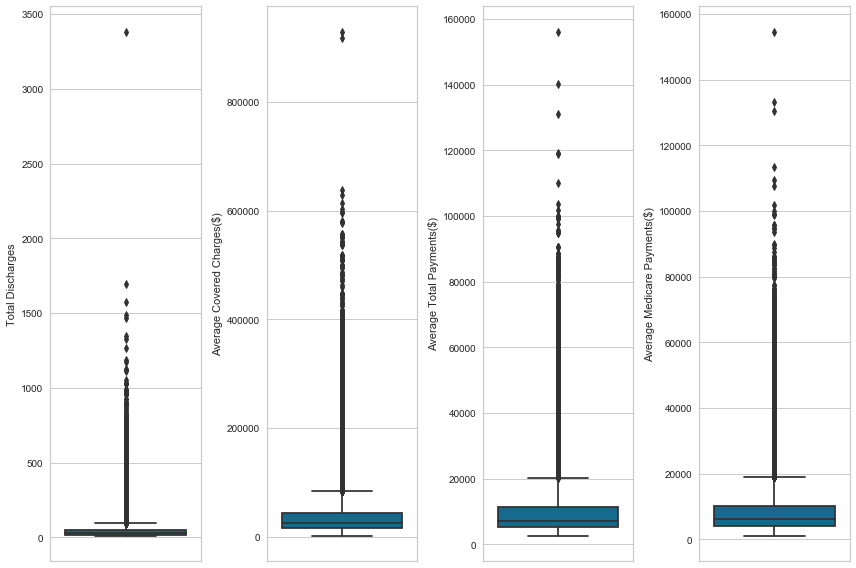

In [184]:
#visulisation by seaborn 
fig,axes=plt.subplots(1,4,figsize=(12,8))
sns.boxplot(y='Total Discharges', data=df, ax=axes[0])
sns.boxplot(y="Average Covered Charges($)", data=df, ax=axes[1])
sns.boxplot(y="Average Total Payments($)", data=df, ax=axes[2])
sns.boxplot(y="Average Medicare Payments($)",data=df, ax=axes[3])
plt.tight_layout()
# it is clear that each numeric feature has outliers, and almost outliers are concentrated around max not min
# so no need to floor but only cap

In [185]:
#then we check the 95% & 99% percentile of these four features (do not need to check small-value outliers)
columns = ['Total Discharges', 'Average Covered Charges($)','Average Total Payments($)','Average Medicare Payments($)']
for col in columns:
    print(df[col].describe(percentiles=[0.95,0.99]).apply(lambda x: format(x, '.2f')))
# then we could find max is even much greater than 99% percentile, so here, i will cap the outliers at 99% 

count    163065.00
mean         42.78
std          51.10
min          11.00
50%          27.00
95%         123.00
99%         242.00
max        3383.00
Name: Total Discharges, dtype: object
count    163065.00
mean      36133.95
std       35065.37
min        2459.40
50%       25245.82
95%       98722.97
99%      176748.51
max      929118.90
Name: Average Covered Charges($), dtype: object
count    163065.00
mean       9707.47
std        7664.64
min        2673.00
50%        7214.10
95%       23926.53
99%       41935.66
max      156158.18
Name: Average Total Payments($), dtype: object
count    163065.00
mean       8494.49
std        7309.47
min        1148.90
50%        6158.46
95%       21775.15
99%       39390.63
max      154620.81
Name: Average Medicare Payments($), dtype: object


In [186]:
#i will replace outliers by 99% value 
#for col in columns:
#    df[col] = np.where(df[col] > df[col].quantile(0.99), df[col].quantile(0.99), df[col])

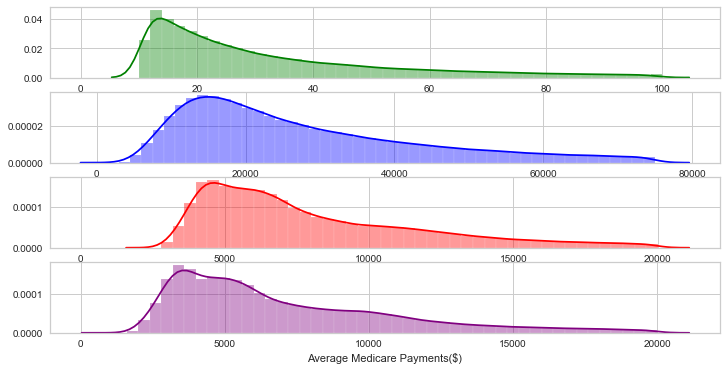

In [187]:
# then we just check the histogram
fig,axes=plt.subplots(4,1,figsize=(12,6))
sns.distplot(df['Total Discharges'],color='green', kde=True, hist=True, kde_kws={"clip":(0,100)},hist_kws={"range": [0,100]}, ax=axes[0])
sns.distplot(df['Average Covered Charges($)'],color='blue',kde_kws={"clip":(0,75000)},hist_kws={"range": [0,75000]}, ax=axes[1])
sns.distplot(df['Average Total Payments($)'],color='red',kde_kws={"clip":(0,20000)}, hist_kws={"range": [0,20000]}, ax=axes[2])
sns.distplot(df['Average Medicare Payments($)'],color='purple',kde_kws={"clip":(0,20000)}, hist_kws={"range": [0,20000]}, ax=axes[3])
# all of these three feature are skewed right, not normally distributed

#### Feature Engineering

##### benchmark & new binary features

First, we need to define the benchmark (here i will use the mean value of each charges group by DRG, State & city respectively) and then derive the ratios

criteria 1:

where ratio > 1 as outlier

new columns:
'Average_Covered_Charge_higher_range'
'Average_Total_Payment_higher_range'
'Average_Medicare_Payments_higher_range'
    

In [191]:
#benchmark for Average Covered Charges($) named as 'Mean - Average Covered Charges($)'
table1 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Covered Charges($)'].apply(lambda x : x.astype(float).mean())
df1 = table1.to_frame()
df1.reset_index(inplace=True)
df1 = df1.rename(columns={'Average Covered Charges($)': 'Mean - Average Covered Charges($)'})

In [192]:
#benchmark for Average Total Payments($) named as 'Mean - Average Total Payments($)'
table2 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).mean())
df2 = table2.to_frame()
df2.reset_index(inplace=True)
df2 = df2.rename(columns={'Average Total Payments($)': 'Mean - Average Total Payments($)'})

In [193]:
#benchmark for Average Medicare Payments($) named as 'Mean - Average Medicare Payments($)'
table3 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).mean())
df3 = table3.to_frame()
df3.reset_index(inplace=True)
df3 = df3.rename(columns={'Average Medicare Payments($)': 'Mean - Average Medicare Payments($)'})

In [194]:
#benchmark for Average Medicare Payments($) named as 'Mean - Total Discharges'
table7 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).mean())
df7 = table7.to_frame()
df7.reset_index(inplace=True)
df7 = df7.rename(columns={'Total Discharges': 'Mean - Total Discharges'})

In [195]:
# merge benchmarks into the original dataset
df = pd.merge(df, df1, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df2, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df3, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df7, on=['DRG Code','Provider State','Provider City'], how='left')

In [196]:
#create new columns to derive the ratios
df['Average_Covered_Charge_Ratio'] = df['Average Covered Charges($)']/df['Mean - Average Covered Charges($)']
df['Average_Total_Payment_Ratio'] = df['Average Total Payments($)']/df['Mean - Average Total Payments($)']
df['Average_Medicare_Payments_Ratio'] = df['Average Medicare Payments($)']/df['Mean - Average Medicare Payments($)']
df['Total_Discharges_Ratio'] = df['Total Discharges']/df['Mean - Total Discharges']

Here, I will sett a criteria that once the ratio is greater than 1, the value will be regarded as higher range (1) else normal range (0)

In [197]:
# identify the higher values (outliers)
df['Average_Covered_Charge_higher_range'] = np.where(df['Average_Covered_Charge_Ratio'] > 1, 1, 0)
df['Average_Total_Payment_higher_range'] = np.where(df['Average_Total_Payment_Ratio'] > 1, 1, 0)
df['Average_Medicare_Payments_higher_range'] = np.where(df['Average_Medicare_Payments_Ratio'] > 1, 1, 0)
df['Total_Discharges_higher_range'] = np.where(df['Total_Discharges_Ratio'] > 1, 1, 0)

criteria 2: 

as mentioned in part 1, I will pick 99% tile (where above as outliers)

new columns: Average_Covered_Charge_above_99, Average_Total_Payment_above_99, Average_Medicare_Payments_above_99, Total_Discharges_above_99

In [198]:
# new columns to identify the 99 percentile by DRG, State & County level 
table4 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Covered Charges($)'].apply(lambda x : x.astype(float).quantile(.99))
df4 = table4.to_frame()
df4.reset_index(inplace=True)
df4 = df4.rename(columns={'Average Covered Charges($)': 'Average_Covered_Charge_99'})

table5 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Total Payments($)'].apply(lambda x : x.astype(float).quantile(.99))
df5 = table5.to_frame()
df5.reset_index(inplace=True)
df5 = df5.rename(columns={'Average Total Payments($)': 'Average_Total_Payment_99'})

table6 = df.groupby(['DRG Code','Provider State','Provider City'])['Average Medicare Payments($)'].apply(lambda x : x.astype(float).quantile(.99))
df6 = table6.to_frame()
df6.reset_index(inplace=True)
df6 = df6.rename(columns={'Average Medicare Payments($)': 'Average_Medicare_Payments_99'})

table8 = df.groupby(['DRG Code','Provider State','Provider City'])['Total Discharges'].apply(lambda x : x.astype(float).quantile(.99))
df8 = table8.to_frame()
df8.reset_index(inplace=True)
df8 = df8.rename(columns={'Total Discharges': 'Total_Discharges_99'})

In [200]:
# merge the above 99 tiles into the original dataset
df = pd.merge(df, df4, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df5, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df6, on=['DRG Code','Provider State','Provider City'], how='left')
df = pd.merge(df, df8, on=['DRG Code','Provider State','Provider City'], how='left')

In [201]:
# identy the outliers whoes value is above 99 tile and create new columns respectively
df['Average_Covered_Charge_above_99'] = np.where(df['Average Covered Charges($)'] > df['Average_Covered_Charge_99'], 1, 0)
df['Average_Total_Payment_above_99'] = np.where(df['Average Total Payments($)'] > df['Average_Total_Payment_99'], 1, 0)
df['Average_Medicare_Payments_above_99'] = np.where(df['Average Medicare Payments($)'] > df['Average_Medicare_Payments_99'], 1, 0)
df['Total_Discharges_above_99'] = np.where(df['Total Discharges'] > df['Total_Discharges_99'], 1, 0)

##### binning numeric variables

In [220]:
df.drop(['Total_Discharges_bin', 'Average Covered Charges_bin','Average Total Payments_bin','Average Medicare Payments_bin'], axis=1, inplace=True)

In [222]:
#binning: encoding each numerical features into 4 subgroups (0,20%,40&,60%,80%)
df['Total_Discharges_bin'] = pd.cut(df['Total_Discharges_Ratio'], bins=4, duplicates='drop',labels=False)
df['Average Covered Charges_bin'] = pd.cut(df['Average_Covered_Charge_Ratio'], bins=4, labels=False)
df['Average Total Payments_bin'] = pd.cut(df['Average_Total_Payment_Ratio'], bins=4, labels=False)
df['Average Medicare Payments_bin'] = pd.cut(df['Average_Medicare_Payments_Ratio'], bins=4, labels=False)

#### EDA

#### higher range VS normal range & above 99 tile VS below 99 tile

First, we could have a general learning about the distribution of higher range/ above 99 tile(outliers) of each index. The following 4 figures show the distribution of high value and low value for respective index (it has been grouped by DRG, state and city). 

Then we could find, no matter for what attribute, the distibution is similar, so i guess there are some relationship between these four attributes (they may carry the same information. e.g. if the provider has noticeably high average total payments, its total discharges will be very high as well).

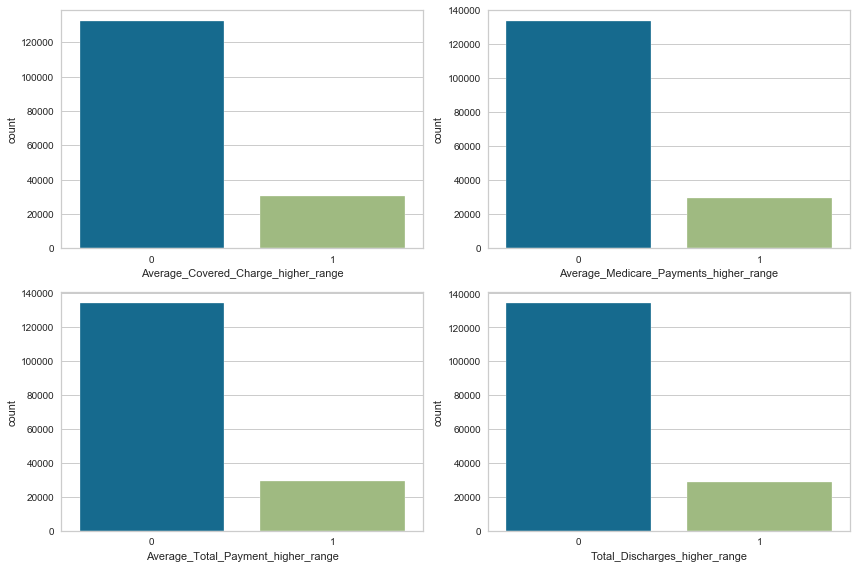

In [216]:
fig,axarr=plt.subplots(2,2,figsize=(12,8))
sns.countplot(x='Average_Covered_Charge_higher_range',data=df, ax=axarr[0][0])
sns.countplot(x='Average_Total_Payment_higher_range', data=df, ax=axarr[1][0])
sns.countplot(x='Average_Medicare_Payments_higher_range', data=df, ax=axarr[0][1])
sns.countplot(x="Total_Discharges_higher_range",data=df, ax=axarr[1][1])
plt.tight_layout()

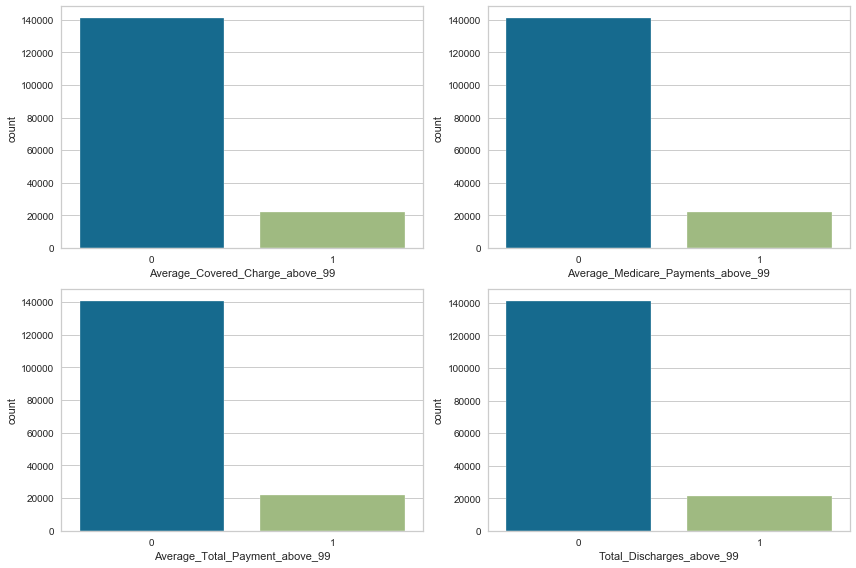

In [225]:
fig,axarr=plt.subplots(2,2,figsize=(12,8))
sns.countplot(x='Average_Covered_Charge_above_99',data=df, ax=axarr[0][0])
sns.countplot(x='Average_Total_Payment_above_99', data=df, ax=axarr[1][0])
sns.countplot(x='Average_Medicare_Payments_above_99', data=df, ax=axarr[0][1])
sns.countplot(x="Total_Discharges_above_99",data=df, ax=axarr[1][1])
plt.tight_layout()

##### Top most expensive DRG treatment

Among outliers (above 99%), we could find that some DRGs are very expensive in whatever state or city (as shown in the first plot) such as 470,292,398. the second figure tells us that the top 5 expensive treatments are those for 207,329,460,853 and 870

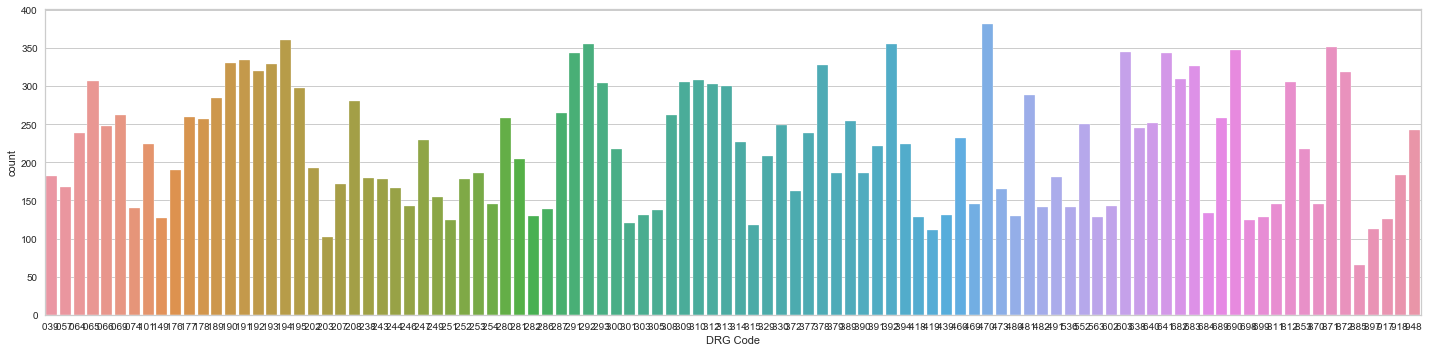

In [247]:
df9 = df.loc[(df['Average_Total_Payment_above_99']==1)].sort_values('Average Total Payments($)', ascending =False)
plt.figure(figsize=(20,5))
sns.countplot(x='DRG Code',data=df9)
plt.tight_layout()

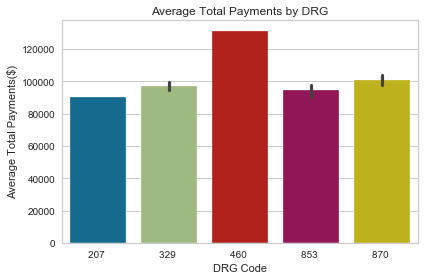

In [251]:
df9 = df.loc[(df['Average_Total_Payment_above_99']==1)].sort_values('Average Total Payments($)', ascending =False).head(10)
sns.barplot(x='DRG Code', y='Average Total Payments($)', data=df9)
plt.title('Average Total Payments by DRG', fontsize=12)
plt.tight_layout()

##### most common DRG

Among the most expensive DRGs, the most common DRGs are 247, 392, 470,885

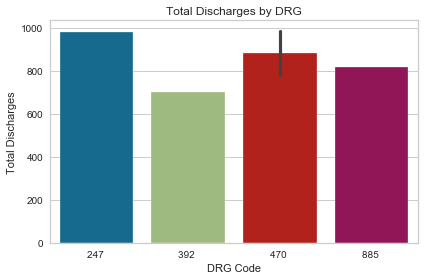

In [252]:
df10 = df.loc[(df['Average_Total_Payment_above_99']==1)].sort_values('Total Discharges', ascending =False).head(10)
sns.barplot(x='DRG Code', y='Total Discharges', data=df10)
plt.title('Total Discharges by DRG', fontsize=12)
plt.tight_layout()

#### k-means clustering

Firstly, i will select out the features i will use in this clustering algorithem and form a new datafram in order to make modelling easier.
Here, i will pick four ratio features and 8 binary features created in part 2

In [425]:
# pick out useful features and form a new dataframe to complete the clustering
df_c = df[['Average_Covered_Charge_higher_range',
       'Average_Total_Payment_higher_range',
       'Average_Medicare_Payments_higher_range',
       'Total_Discharges_higher_range', 'Average_Covered_Charge_above_99',
       'Average_Total_Payment_above_99', 'Average_Medicare_Payments_above_99',
       'Total_Discharges_above_99',
       'Average_Covered_Charge_Ratio', 'Average_Total_Payment_Ratio',
       'Average_Medicare_Payments_Ratio', 'Total_Discharges_Ratio']]

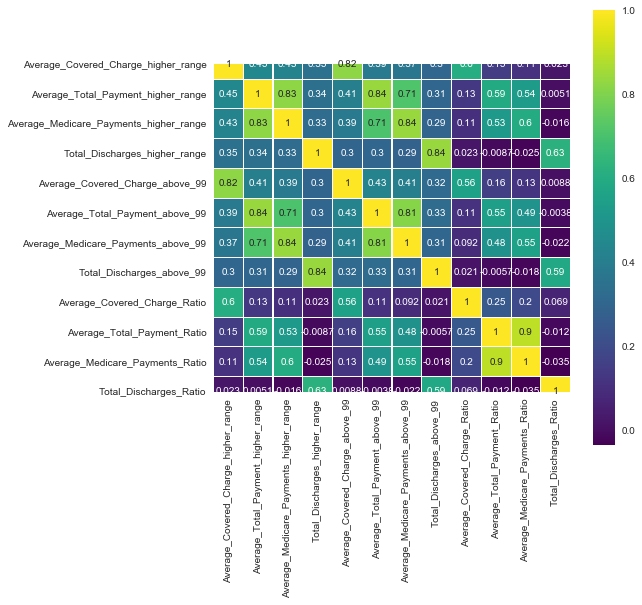

In [261]:
# check the correlation between each attributes
colormap = plt.cm.viridis
plt.figure(figsize=(8,8))
sns.heatmap(df_c.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

Then we could find from the above heatmap that the absolute correlations between Average_Total_Payment_higher_range and Average_Medicare_Payments_higher_range/ between Average_Covered_Charge_above_99 and Average_Covered_Charge_higher_range/ between Average_Medicare_Payments_higher_range and Average_Total_Payment_99 are very high (above o.8, the highest in our dataset), so they are probably carrying the same information and using two similarities as inputs for the same model may not be a good idea. High chances are redundant variables, so here, I'll choose average medicare_payments_higher_range, average_total_payments_99,'Average_Covered_Charge_99' and Total_Discharges_higher_range. 

In [426]:
df_c.drop(['Average_Medicare_Payments_above_99', 'Average_Total_Payment_higher_range','Average_Covered_Charge_higher_range','Total_Discharges_above_99'], axis=1, inplace=True)

##### Scaling

All the variables should be on the same scale before clustering.scale of the variable (e.g., seconds vs minutes) affects the weight assigned to the variable. Therefore, it is best to
standardize variables.

In [427]:
df_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163065 entries, 0 to 163064
Data columns (total 8 columns):
Average_Medicare_Payments_higher_range    163065 non-null int64
Total_Discharges_higher_range             163065 non-null int64
Average_Covered_Charge_above_99           163065 non-null int64
Average_Total_Payment_above_99            163065 non-null int64
Average_Covered_Charge_Ratio              163065 non-null float64
Average_Total_Payment_Ratio               163065 non-null float64
Average_Medicare_Payments_Ratio           163065 non-null float64
Total_Discharges_Ratio                    163065 non-null float64
dtypes: float64(4), int64(4)
memory usage: 16.2 MB


In [428]:
from sklearn.preprocessing import StandardScaler
x = df_c
#[['Average_Medicare_Payments_higher_range','Total_Discharges_higher_range','Average_Covered_Charge_above_99','Average_Total_Payment_above_99']]
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

##### Best number of clusters

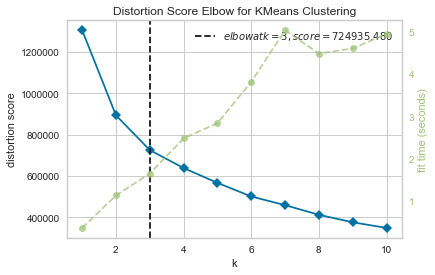

In [373]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(init='k-means++'), k=(1,11))
visualizer.fit(x)        # Fit the data to the visualizer
visualizer.show()
# in this case we could find that 3 is the most appropriate number of clusters

In [429]:
# so the number of clusters will be 3
kmeans = KMeans(n_clusters= 3 , init='k-means++').fit(x)
y_kmeans = kmeans.predict(x)
df1_c=pd.DataFrame(kmeans.cluster_centers_,columns=df_c.columns)

In [430]:
print(df1_c)

   Average_Medicare_Payments_higher_range  Total_Discharges_higher_range  \
0                               -0.003607                       2.148149   
1                               -0.389921                      -0.465368   
2                                2.002290                       0.654260   

   Average_Covered_Charge_above_99  Average_Total_Payment_above_99  \
0                         0.359598                       -0.204624   
1                        -0.284719                       -0.380808   
2                         1.170006                        2.117631   

   Average_Covered_Charge_Ratio  Average_Total_Payment_Ratio  \
0                     -0.197514                    -0.757805   
1                     -0.063171                    -0.157856   
2                      0.483169                     1.420423   

   Average_Medicare_Payments_Ratio  Total_Discharges_Ratio  
0                        -0.777529                1.463111  
1                        -0.152728 

In [431]:
unique, counts = np.unique(y_kmeans, return_counts=True)
dict(zip(unique, counts))

{0: 18955, 1: 120587, 2: 23523}

In [432]:
df['k_segments_3'] = y_kmeans

In [435]:
df_c1 = df.loc[df['k_segments_3'] == 0]
df_c2 = df.loc[df['k_segments_3'] == 1]
df_c3 = df.loc[df['k_segments_3'] == 2]

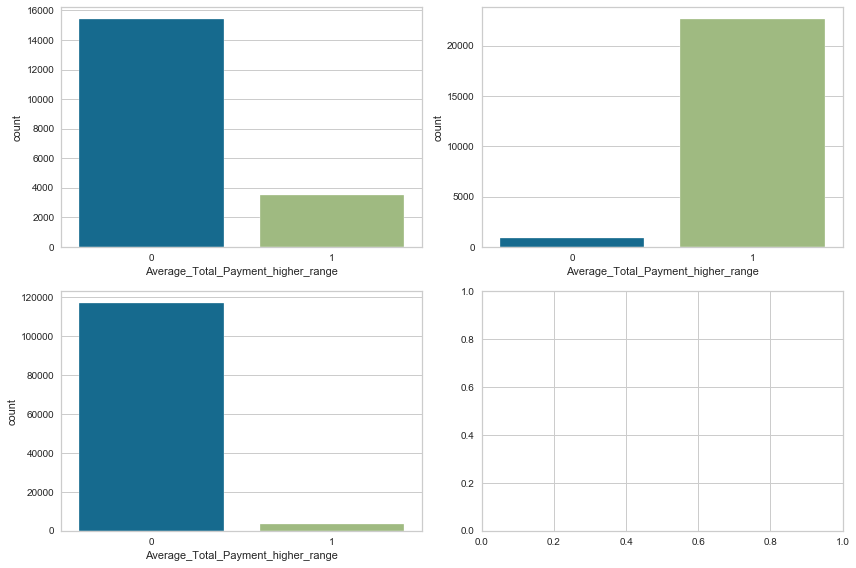

In [446]:
# to see the distribution of higher range in each clusters
fig,axarr=plt.subplots(2,2,figsize=(12,8))
sns.countplot(x='Average_Total_Payment_higher_range',data=df_c1, ax=axarr[0][0])
sns.countplot(x='Average_Total_Payment_higher_range', data=df_c2, ax=axarr[1][0])
sns.countplot(x='Average_Total_Payment_higher_range', data=df_c3, ax=axarr[0][1])
plt.tight_layout()

The above figures show that in cluster # 2, all of providers provide more expensive treatments for DRG. To explore more, we could compare cluster # 0 and cluster # 2

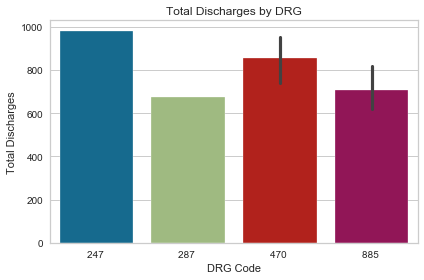

In [439]:
#cluster 2
df_c31 = df_c3.sort_values('Total Discharges', ascending = False).head(10)
sns.barplot(x='DRG Code', y='Total Discharges', data=df_c31)
plt.title('Total Discharges by DRG', fontsize=12)
plt.tight_layout()

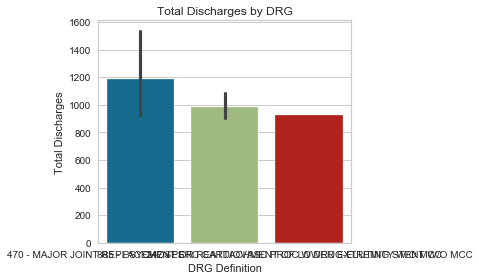

In [458]:
#cluster 0
df_c21 = df_c2.sort_values('Total Discharges', ascending = False).head(10)
sns.barplot(x='DRG Definition', y='Total Discharges', data=df_c21)
plt.title('Total Discharges by DRG', fontsize=12)
plt.tight_layout()

Then we could find that DRG 247 470 and 885 are most common in the clusters whose values are normal but they are also very common in the clusters whose values are higher. This may indicate that these three DRGs are always misused by the suspicious providers. Then we could find out which providers have the greatest total discharges for these three DGRS and then we could suspect these providers as potential frauds. 

In [461]:
df_c3.loc[df['DRG Definition']=='247 - PERC CARDIOVASC PROC W DRUG-ELUTING STENT W/O MCC'].sort_values('Total Discharges', ascending = False).head(1)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges($),...,Average_Covered_Charge_above_99,Average_Total_Payment_above_99,Average_Medicare_Payments_above_99,Total_Discharges_above_99,Total_Discharges_bin,Average Covered Charges_bin,Average Total Payments_bin,Average Medicare Payments_bin,k_segments_5,k_segments_3
47749,247 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,340069,"WAKEMED, RALEIGH CAMPUS",3000 NEW BERN AVE,RALEIGH,NC,27610,NC - Raleigh,981,69881.85,...,0,1,1,1,1,0,0,0,3,2


In [463]:
df_c3.loc[df['DRG Definition']=='470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W/O MCC'].sort_values('Total Discharges', ascending = False).head(1)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges($),...,Average_Covered_Charge_above_99,Average_Total_Payment_above_99,Average_Medicare_Payments_above_99,Total_Discharges_above_99,Total_Discharges_bin,Average Covered Charges_bin,Average Total Payments_bin,Average Medicare Payments_bin,k_segments_5,k_segments_3
111734,470 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,100018,NAPLES COMMUNITY HOSPITAL,350 7TH ST N,NAPLES,FL,34102,FL - Fort Myers,1032,40478.41,...,0,1,1,1,1,0,0,0,3,2


In [464]:
df_c3.loc[df['DRG Definition']=='885 - PSYCHOSES'].sort_values('Total Discharges', ascending = False).head(1)

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges($),...,Average_Covered_Charge_above_99,Average_Total_Payment_above_99,Average_Medicare_Payments_above_99,Total_Discharges_above_99,Total_Discharges_bin,Average Covered Charges_bin,Average Total Payments_bin,Average Medicare Payments_bin,k_segments_5,k_segments_3
157597,885 - PSYCHOSES,50277,PACIFIC HOSPITAL OF LONG BEACH,2776 PACIFIC AVE,LONG BEACH,CA,90806,CA - Los Angeles,818,19612.17,...,0,1,1,1,1,0,1,0,3,2


Therefore, providers named ' WAKEMED, RALEIGH CAMPUS' ,'NAPLES COMMUNITY HOSPITAL' and 'PACIFIC HOSPITAL OF LONG BEACH'are suspicious 